In [1]:
import os
import datetime
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import models
from tqdm.auto import tqdm
import sys
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


In [2]:
DATA_DIR = os.path.expanduser("~/Zoidberg/data/raw/chest_Xray/train")
MODEL_DIR = os.path.expanduser("~/Zoidberg/models")
DOCS_DIR = os.path.expanduser("~/Zoidberg/docs")
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = os.path.join(MODEL_DIR, f"mobilenet_pneumonia_{TIMESTAMP}.pt")


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def load_dataset():
    class_map = {"NORMAL": 0, "bacterial": 1, "viral": 2}
    dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
    new_samples = []
    for path, _ in dataset.samples:
        fname = os.path.basename(path).lower()
        label = class_map["bacterial"] if "bacteria" in fname else (class_map["viral"] if "pneumonia" in fname else class_map["NORMAL"])
        new_samples.append((path, label))
    dataset.samples = new_samples
    dataset.targets = [s[1] for s in new_samples]
    dataset.classes = ["NORMAL", "bacterial", "viral"]
    return dataset

dataset = load_dataset()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)


In [4]:
train_losses, train_accuracies = [] ,[]
def train():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.last_channel, 3)
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")
        loop = tqdm(train_loader, desc="Batchs", leave=True)
        for inputs, labels in loop:
            try:
                inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                loop.set_postfix({"loss": f"{running_loss / (total / BATCH_SIZE):.4f}", "acc": f"{correct / total:.4f}"})
                del inputs, labels, outputs, preds, loss
                torch.cuda.empty_cache()
            except RuntimeError as e:
                print(f"Erreur CUDA : {e}")
                torch.cuda.empty_cache()
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"📦 Modèle sauvegardé dans : {MODEL_PATH}")
    return model
model = train()



🔁 Epoch 1/5


/home/zoidberg/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batchs:   0%|          | 0/522 [00:00<?, ?it/s]


🔁 Epoch 2/5


Batchs:   0%|          | 0/522 [00:00<?, ?it/s]


🔁 Epoch 3/5


Batchs:   0%|          | 0/522 [00:00<?, ?it/s]


🔁 Epoch 4/5


Batchs:   0%|          | 0/522 [00:00<?, ?it/s]


🔁 Epoch 5/5


Batchs:   0%|          | 0/522 [00:00<?, ?it/s]

📦 Modèle sauvegardé dans : /home/zoidberg/Zoidberg/models/mobilenet_pneumonia_20250523_112743.pt


Évaluation:   0%|          | 0/131 [00:00<?, ?it/s]

📊 Répartition réelle : Counter({np.int64(0): 525, np.int64(1): 519})
📊 Répartition prédite : Counter({np.int64(0): 614, np.int64(1): 430})
              precision    recall  f1-score   support

      NORMAL       0.76      0.89      0.82       525
   bacterial       0.87      0.72      0.78       519
       viral       0.00      0.00      0.00         0

    accuracy                           0.80      1044
   macro avg       0.54      0.54      0.53      1044
weighted avg       0.81      0.80      0.80      1044



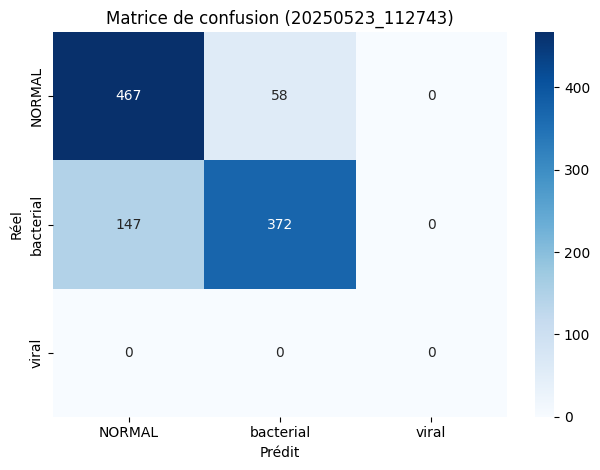

In [5]:
model.eval()
y_true, y_pred = [], []
class_indices = [0, 1, 2]
with torch.no_grad():
    for inputs, labels_batch in tqdm(val_loader, desc="Évaluation"):
        inputs, labels_batch = inputs.to(DEVICE), labels_batch.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
print("📊 Répartition réelle :", Counter(y_true))
print("📊 Répartition prédite :", Counter(y_pred))
cm = confusion_matrix(y_true, y_pred, labels=class_indices)
report = classification_report(y_true, y_pred, labels=class_indices, target_names=dataset.classes, zero_division=0)
print(report)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title(f"Matrice de confusion ({TIMESTAMP})")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()
